Measuring backgrounds for multiple deep fields: lensing clusters SMACS0723 and Abell2744, and Windhorst's north ecliptic pole field which is public (called 'NEP-TDF').  Using Jane's re-reduction of NIRCam and NIRISS data from Sept 2022.  Since NIRCam flux calibration is not settled yet, doing photometry for NIRCam on RATE files, and then applying a few different flux calibrations and comparing them, using the PHOTMJSR keyword.  For NIRISS, Chris Willott says to trust the fluxing in the pipeline, so using CAL files.  
-jrigby 15 Sept 2022

Have tested this for SMACS0723 and Abell2744; this notebook replaces those indy notebooks.  Later added NEP

In [57]:
import jrr    #https://github.com/janerigby/jrr
from os.path import basename
import glob
import numpy as np
import astropy
from astropy.io import fits
from astropy.stats import sigma_clipped_stats
import matplotlib.pyplot as plt
import matplotlib
from matplotlib.backends.backend_pdf import PdfPages
from cycler import cycler
import pandas
from re import sub, split
import warnings
from astropy.io import ascii

In [58]:
warnings.filterwarnings("ignore")
plt.rcParams['figure.figsize'] = [12, 8]
matplotlib.rcParams.update({'font.size': 22})

In [59]:
def group_the_df(df, statcol='median', by=['detector', 'filtername', 'observtn'], \
                by2 = ['instrument', 'filtername', 'observtn']):
    grouped = df.groupby(by=by).median().reset_index()
    std_of_grouped = df.groupby(by=by).std().reset_index()
    grouped[statcol + '_std'] = std_of_grouped[statcol]  # Grab standard dev, and put it in grouped
    grouped['shortdet'] = grouped['detector'].str.replace('NRC', '').str.replace('MIRIMAGE', 'MIRI')
    grouped.loc[grouped.detector == 'NRCB1'].tail()
    grouped.tail()
    
    # again, but combine all NIRCam detectors together
    grouped2 = df.groupby(by=by2).median().reset_index() 
    std_of_grouped = df.groupby(by=by2).std().reset_index()
    grouped2[statcol + '_std'] = std_of_grouped[statcol]  # Grab standard dev, and put it in grouped
    #grouped2.loc[(grouped2.instrument == 'NIRCAM') & (grouped2.filtername == 'F200W')].head(10)
    return(grouped, grouped2)

In [60]:
# ***** MODIFY THESE NEXT LINES **** #
observation_name = 'NEP-TDF'  # choices are 'smacs0723', 'abell2744', 'NEP-TDF'
whos_fluxing = 'martha2'  # Whose fluxing should we use?
redo_phot = False   # It is time consuming to redo all the photometry.  Only do this if something changed
repredict_backgrounds = False  # If no internet, don't re-predict backgrounds. For planes
use_simple_title = True
# ********************************** #

if observation_name == 'smacs0723' :
    datadir = '/Users/jrrigby1/SCIENCE/JWST_Data/EROs/SMACS_0723/'
    pid = '02736'
    nircam_indir   = datadir + 'NIRCam_L2a/'        # Reduced by JRR  on 6 Oct 2022    DN/s (RATES)
    miri_indir     = datadir + 'MIRI_L2/'           # Reduced by Maca on Sep 11 2022.  MJy/sr (CAL)
    niriss_indir   = datadir + 'NIRISS_L2b/'        # Reduced by JRR  on 6 Oct 2022.   MJy/sr (CAL)
    filenames_miri   = [x for x in glob.glob(miri_indir  + "*/*cal.fits") ]
    simple_title = 'SMACSJ0723.3-7327, PID ' + pid
    
elif observation_name == 'abell2744':
    datadir  = '/Users/jrrigby1/SCIENCE/JWST_Data/GLASS/'
    pid = '01324'
    nircam_indir   = datadir + 'Abell2744_nircamL2a/'  # Reduced by JRR on 6 Oct 2022    DN/s (RATES)
    niriss_indir   = datadir + 'Abell2744_niriss_L2b/' # Reduced by JRR on 6 Oct 2022    MJy/sr (CAL)
    simple_title = 'Abell 2744, PID ' + pid
    
elif observation_name == 'NEP-TDF' :
    datadir = '/Users/jrrigby1/SCIENCE/JWST_Data/NEP/'
    pid = '02738'
    nircam_indir = datadir + 'NEP_nircam_L2a/'  # Reduced by JRR 6 Oct 2022   DN/s
    niriss_indir = datadir + 'NEP_niriss_L2b/'  # Reduced by JRR 6 Oct 2022.  MJy/sr
    simple_title = 'NEP-TDF, PID ' + pid
    
# same for all 3 fields
regfile = '/Users/jrrigby1/SCIENCE/JWST_Data/Commis_data/Stray_light/L3/miri_valid_box.reg'
filenames_nircam = [x for x in glob.glob(nircam_indir + "*rate.fits") ]
filenames_niriss = [x for x in glob.glob(niriss_indir  + "*cal.fits") ]
filenames_to_process_as_rates = filenames_nircam

if observation_name == 'smacs0723' :
    filenames_to_process_as_cal   = filenames_miri + filenames_niriss
elif observation_name in ('abell2744', 'NEP-TDF') :
    filenames_to_process_as_cal   = filenames_niriss
else : raise Exception('Do not know which filenames to process as cal for observation', observation_name)

In [61]:
fluxing_dicts = {'marcia'  : jrr.jwst.get_mrieke_fluxcal_aug2022(), \
                 'marcia2' : jrr.jwst.get_mrieke_fluxcal_sept2022(), \
                 'gabe'    : jrr.jwst.get_gbrammer_fluxcal_aug2022(), \
                 'martha2' : jrr.jwst.get_mboyer_fluxcal_sep202022_justdict()} #sept 29 2022 update, right before CRDS

In [62]:
# Translate filter names to approx wavelengths
filter_wave   = jrr.jwst.getwave_for_filter()
filter_width = jrr.jwst.getwidth_for_filter()

In [63]:
savefiles_prefix = observation_name  + '-repro' + '_' + whos_fluxing + '_fluxed'

In [64]:
# Next cell measures all the RATE files (DN/s)

In [65]:
%%capture cap 
if redo_phot:
    clip_sigma = 1 ; clip_grow = 0; clip_maxiters=4  # for sigma clipped median
    print('filtername', 'wave', 'filtwidth', 'date', 'detector', 'x', 'y', 'median', 'median_clipped', 'filename', 'observtn', 'visit', 'instrument', 'effexptime')
    # above is cute magic to print out what's in this cell with nice print formatting
    for thisfile in (filenames_to_process_as_rates):  # file has mulitple headers, so do the long HDU way
        hdu = fits.open(thisfile)
        instrument = hdu[0].header['INSTRUME']
        exptime = hdu[0].header['EFFEXPTM']
        if 'NIRISS' in instrument: filter    = hdu[0].header['pupil']
        else : filter = hdu[0].header['filter']
        median = jrr.util.median_ignore_zero(hdu[1].data)
        (mean, median_clip, stddev) = sigma_clipped_stats(hdu[1].data, maxiters=clip_maxiters, sigma=clip_sigma, grow=clip_grow)
        date_beg = hdu[0].header['date-beg']+'Z' # force zulu to make pandas happy
        print(filter, filter_wave[filter], filter_width[filter], date_beg, hdu[0].header['DETECTOR'], \
            hdu[1].data.shape[0], hdu[1].data.shape[1], median, median_clip, basename(thisfile), \
              hdu[0].header['OBSERVTN'], hdu[0].header['VISIT'], instrument, exptime)

In [66]:
filenames_to_process_as_rates

['/Users/jrrigby1/SCIENCE/JWST_Data/NEP/NEP_nircam_L2a/jw02738002001_06101_00004_nrcb3_rate.fits',
 '/Users/jrrigby1/SCIENCE/JWST_Data/NEP/NEP_nircam_L2a/jw02738002001_12101_00004_nrcalong_rate.fits',
 '/Users/jrrigby1/SCIENCE/JWST_Data/NEP/NEP_nircam_L2a/jw02738002001_12101_00002_nrca2_rate.fits',
 '/Users/jrrigby1/SCIENCE/JWST_Data/NEP/NEP_nircam_L2a/jw02738002001_06101_00003_nrcblong_rate.fits',
 '/Users/jrrigby1/SCIENCE/JWST_Data/NEP/NEP_nircam_L2a/jw02738002001_04101_00002_nrca4_rate.fits',
 '/Users/jrrigby1/SCIENCE/JWST_Data/NEP/NEP_nircam_L2a/jw02738002001_12101_00001_nrcb3_rate.fits',
 '/Users/jrrigby1/SCIENCE/JWST_Data/NEP/NEP_nircam_L2a/jw02738002002_02101_00002_nrca2_rate.fits',
 '/Users/jrrigby1/SCIENCE/JWST_Data/NEP/NEP_nircam_L2a/jw02738002001_04101_00004_nrcalong_rate.fits',
 '/Users/jrrigby1/SCIENCE/JWST_Data/NEP/NEP_nircam_L2a/jw02738002001_02101_00004_nrcb3_rate.fits',
 '/Users/jrrigby1/SCIENCE/JWST_Data/NEP/NEP_nircam_L2a/jw02738002002_02101_00001_nrcb3_rate.fits',
 

In [67]:
statsfile1 = savefiles_prefix + "-backgrounds_rates.txt"
if redo_phot:
    with open(statsfile1, 'w') as f:
        f.write(cap.stdout)

In [68]:
# Apply fluxing to the rate files
df1 = pandas.read_csv(statsfile1, delim_whitespace=True)
thisfluxing_dict = fluxing_dicts[whos_fluxing]  # load the fluxing dictionary 
df1['dummycol'] = df1['filtername'] + '_' + df1['detector']
df1['PHOTMJSR'] = df1['dummycol'].map(thisfluxing_dict)
df1['sb_mjsr'] = df1['median'] * df1['PHOTMJSR']
df1.drop('dummycol', inplace=True, axis=1)
#df1.head()

Good, I don't see evidence that the flux measured depends on exposure time.


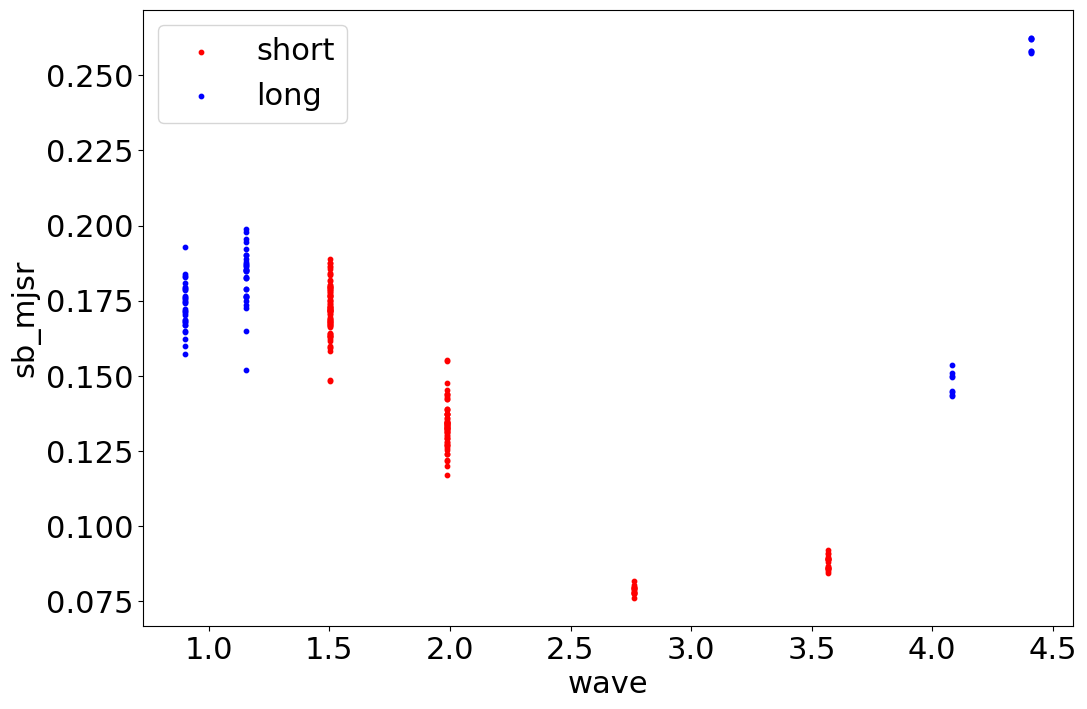

In [69]:
timecutoff = 500.
short_subset = df1.loc[df1.effexptime.lt(timecutoff)]
long_subset  = df1.loc[df1.effexptime.gt(timecutoff)]
ax= short_subset.plot(x='wave', y='sb_mjsr', kind='scatter', color='red', label='short', s=10)
long_subset.plot(    x='wave', y='sb_mjsr', kind='scatter', color='blue', label='long', s=10, ax=ax)
print("Good, I don't see evidence that the flux measured depends on exposure time.")

In [70]:
# Next cell measures all the FLUXED CAL files (MJy/SR)

In [71]:
%%capture cap 
if redo_phot:
    clip_sigma = 1 ; clip_grow = 0; clip_maxiters=4  # for sigma clipped median
    print('filtername', 'wave', 'filtwidth', 'date', 'detector', 'x', 'y', 'median', 'median_clipped', 'filename', 'observtn', 'visit', 'instrument', 'effexptime')
    for thisfile in (filenames_to_process_as_cal):  # file has mulitple headers, so do the long HDU way
        hdu = fits.open(thisfile)
        instrument = hdu[0].header['INSTRUME']
        exptime = hdu[0].header['EFFEXPTM']
        if 'NIRISS' in instrument: filter    = hdu[0].header['pupil']
        else : filter = hdu[0].header['filter']

        if 'MIRI' in instrument :
            label = 'foo'
            foo = jrr.phot.wrap_simple_region_photometry(thisfile, regfile, prefix=label, override_label=basename(thisfile), \
                  clip_sigma=clip_sigma, clip_grow=clip_grow, clip_maxiters=clip_maxiters)
            median      = (foo[label + 'median']).values[0]
            median_clip = (foo[label + 'clipped_median']).values[0]
        else :
            median = np.median(hdu[1].data) 
            (mean, median_clip, stddev) = sigma_clipped_stats(hdu[1].data, maxiters=clip_maxiters, sigma=clip_sigma, grow=clip_grow)
        date_beg = hdu[0].header['date-beg']+'Z' # force zulu to make pandas happy
        print(filter, filter_wave[filter], filter_width[filter], date_beg, hdu[0].header['DETECTOR'], \
            hdu[1].data.shape[0], hdu[1].data.shape[1], median, median_clip, basename(thisfile), \
              hdu[0].header['OBSERVTN'], hdu[0].header['VISIT'], instrument, exptime)

In [72]:
statsfile2 = savefiles_prefix +  "-backgrounds_cal.txt"
if redo_phot: 
    with open(statsfile2, 'w') as f:
        f.write(cap.stdout)

In [73]:
df2 = pandas.read_csv(statsfile2, delim_whitespace=True)  # Read the calibrated files.  
df2['sb_mjsr'] = df2['median'] #Already in MJy/sr units

In [74]:
#plt.scatter(df.wave, df['median'] * df.PHOTMJSR)

In [75]:
grouped1_df1, grouped2_df1 = group_the_df(df1, statcol='sb_mjsr')
grouped1_df2, grouped2_df2 = group_the_df(df2, statcol='sb_mjsr')
grouped1_df1.loc[grouped1_df1.filtername.eq('F200W')].head(10)

,detector,filtername,observtn,wave,filtwidth,x,y,median,median_clipped,visit,effexptime,PHOTMJSR,sb_mjsr,sb_mjsr_std,shortdet
3,NRCA1,F200W,2,1.989,0.457,2048.0,2048.0,0.068247,0.067838,1.0,418.734,1.8917,0.129102,0.005901,A1
7,NRCA2,F200W,2,1.989,0.457,2048.0,2048.0,0.064405,0.064242,1.0,418.734,2.0807,0.134009,0.011175,A2
11,NRCA3,F200W,2,1.989,0.457,2048.0,2048.0,0.072203,0.071623,1.0,418.734,1.8281,0.131994,0.002206,A3
15,NRCA4,F200W,2,1.989,0.457,2048.0,2048.0,0.074038,0.073563,1.0,418.734,1.8054,0.133669,0.003866,A4
23,NRCB1,F200W,2,1.989,0.457,2048.0,2048.0,0.067208,0.066942,1.0,418.734,2.0223,0.135914,0.007455,B1
27,NRCB2,F200W,2,1.989,0.457,2048.0,2048.0,0.068715,0.068205,1.0,418.734,1.9519,0.134125,0.006347,B2
31,NRCB3,F200W,2,1.989,0.457,2048.0,2048.0,0.070495,0.069920,1.0,418.734,1.9572,0.137973,0.006409,B3
35,NRCB4,F200W,2,1.989,0.457,2048.0,2048.0,0.073506,0.072597,1.0,418.734,1.7715,0.130216,0.008157,B4


In [76]:
# Dump dataframes to files for record-keeping
df1.to_csv(savefiles_prefix + "-df1.txt", index=False)
df2.to_csv(savefiles_prefix + "-df2.txt", index=False)
grouped1_df1.to_csv(savefiles_prefix + "-df1-grouped.txt", index=False)
grouped1_df2.to_csv(savefiles_prefix + "-df2-grouped.txt", index=False)

In [77]:
#SMACS 0723 observed over a range of dates.
# DATE-OBS:  MIRI 2022-06-14    # NIRCam 2022-06-07  #NIRISS XX  NIRSpec XX
bkg_df = {}
allfiles = filenames_to_process_as_cal + filenames_to_process_as_rates
files_to_predict_bkg_from = {}
lastdate = '2021-12-25'  # not pythonic but whatever
unique_dateobs = []
for thisfile in allfiles :
    dateobs = jrr.util.gethead(thisfile, 'DATE-OBS',0)
    if dateobs != lastdate :
        print("New date identified", dateobs)
        files_to_predict_bkg_from[dateobs] = thisfile
        outfile = observation_name + '_predictedbkg_date' + dateobs +   '.txt'
        if repredict_backgrounds :
            bkg_df[dateobs] = jrr.jwst.get_background_for_jwstfile(thisfile, bkg_file=outfile, plot_bathtub=False, showsubbkgs=False)
        else : 
            bkg_df[dateobs] = jrr.jwst.open_background_file(outfile)
        unique_dateobs.append(dateobs)
        lastdate = dateobs # update my hokey counter

New date identified 2022-08-26
New date identified 2022-08-30
New date identified 2022-08-26
New date identified 2022-08-30
New date identified 2022-08-26
New date identified 2022-08-30
New date identified 2022-08-26
New date identified 2022-08-30
New date identified 2022-08-26
New date identified 2022-08-30
New date identified 2022-08-26
New date identified 2022-08-30
New date identified 2022-08-26
New date identified 2022-08-30
New date identified 2022-08-26
New date identified 2022-08-30
New date identified 2022-08-26
New date identified 2022-08-30
New date identified 2022-08-26
New date identified 2022-08-30
New date identified 2022-08-26
New date identified 2022-08-30
New date identified 2022-08-26
New date identified 2022-08-30
New date identified 2022-08-26
New date identified 2022-08-30
New date identified 2022-08-26
New date identified 2022-08-30
New date identified 2022-08-26
New date identified 2022-08-30
New date identified 2022-08-26
New date identified 2022-08-30
New date

In [78]:
#grouped2_df2.head()

In [79]:
def plot_dfs_new(grouped1_df1, grouped1_df2, grouped2_df1, grouped2_df2, statcol='sb_mjsr', annotate=True):
    # grouped1 is for each detector, grouped2 is the median of all detectors
    # _df1 is measured from RATES (DN/s).   _df2 is measured from CAL (calibratd files, MJy/sr)
    df = grouped1_df1 ;  plt.scatter(df['wave'], df[statcol], color='k', s=30)  # Plot indiividual points per detector
    df = grouped1_df2 ;  plt.scatter(df['wave'], df[statcol], color='r', s=150)

    df = grouped2_df1 ;  plt.scatter(df['wave'], df[statcol], color='purple', marker='*', s=240) # Plot median over multiple detectors
    # grouped2_dfx has the median over multiple detectors.  This is only relevant for NIRCam, so do a subset
    df = grouped2_df2.loc[grouped2_df2['instrument'].eq('NIRCAM')] ;  plt.scatter(df['wave'], df[statcol], color='pink', marker='P', s=160)

    df = grouped1_df2.loc[grouped1_df2.detector.eq('MIRIMAGE')]
    plt.errorbar(df['wave'], df[statcol], xerr=df['filtwidth'] / 2.0, color='k', ls='none', capsize=10, lw=2)
    
    if annotate:
        for df in (grouped1_df1, grouped1_df2):
            jrr.plot.annotate_from_dataframe(df, 'wave', statcol, 'shortdet', xytext=(-7,0), fontsize=10)
    return(0)

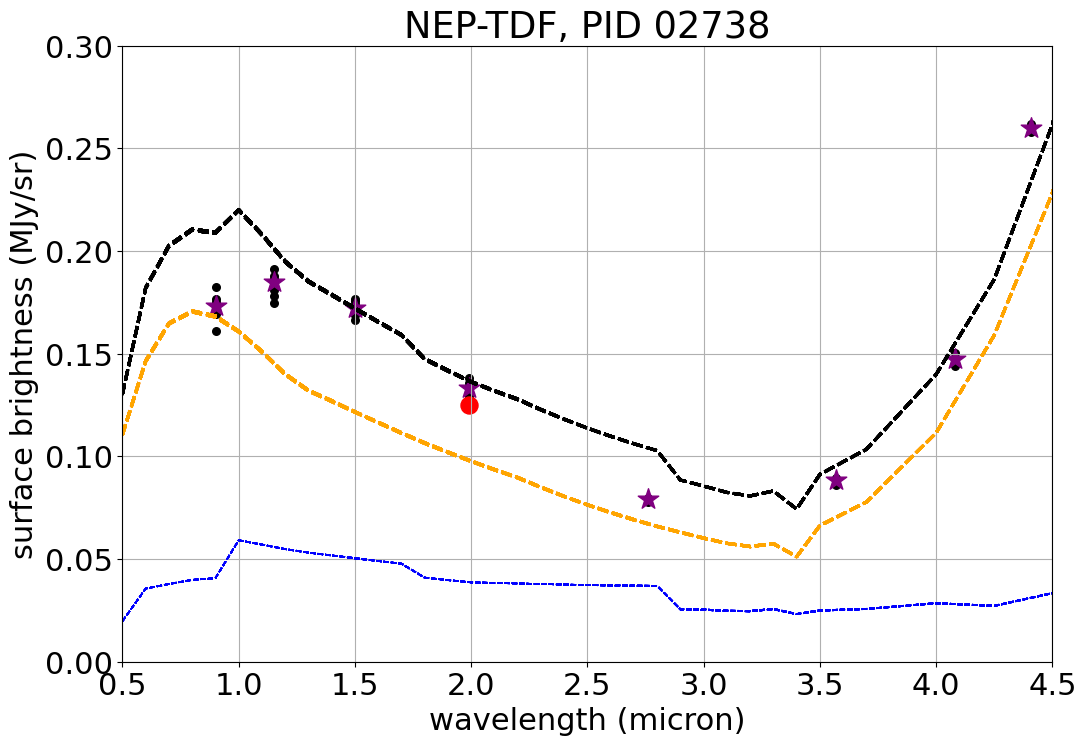

In [80]:
# PLOT EVERYTHING!
the_pdf = observation_name + '_' + whos_fluxing + '_fluxing_backgrounds.pdf'
plt.rcParams['figure.figsize'] = [12, 8]
pp = PdfPages(the_pdf)  # output 
statcol = 'sb_mjsr'

plot_dfs_new(grouped1_df1, grouped1_df2, grouped2_df1, grouped2_df2, statcol='sb_mjsr', annotate=False)
scale_straylight = 1.0
if use_simple_title : plt.title(simple_title)
else:             plt.title(observation_name + " w " + whos_fluxing + " flux calib; stray light scaled x"
          + str(scale_straylight))

for dateobs in unique_dateobs :
    jrr.jwst.plot_expected_bkgs(bkg_df[dateobs], scalestray=scale_straylight, plotlegend=False, plotthermal=False)

plt.ylim(0.0, 0.3)
plt.xlim(0.5,4.5)
plt.grid(visible=True)
plt.xlabel("wavelength (micron)")
plt.ylabel("surface brightness (MJy/sr)")
pp.savefig()
plt.show()
pp.close()

In [81]:
simple_title

'NEP-TDF, PID 02738'

In [82]:
# Again, but mid-IR
if observation_name == 'smacs0723' :
    the_pdf = observation_name + '_midIR_' + whos_fluxing + '_fluxing_backgrounds.pdf'
    pp = PdfPages(the_pdf)  # output 
    statcol = 'sb_mjsr'

    plot_dfs_new(grouped1_df1, grouped1_df2, grouped2_df1, grouped2_df2, statcol='sb_mjsr')
    scale_straylight = 1
    plt.title(observation_name + " w " + whos_fluxing + " flux calib; stray light scaled x"
              + str(scale_straylight))
    for dateobs in unique_dateobs :
        jrr.jwst.plot_expected_bkgs(bkg_df[dateobs], scalestray=scale_straylight, plotlegend=False, plotthermal=True)
    plt.ylim(0.0, 100)
    plt.xlim(0.5,20)
    plt.xlabel("wavelength (micron)")
    plt.ylabel("surface brightness (MJy/sr)")
    pp.savefig()
    plt.show()
    pp.close()

## What I did, in words, for documentation and maybe a paper later.  
Here are my results on the near-IR stray light results for NIRCam and NIRISS, for the lensing cluster SMACS0723 (the ERO).

For NIRCam, I re-reduced the data using the jwst pipeline, so that all the latest calibrations are applied.  I then measure the median of the RATE images (in units of DN/s), so that I can experiment with different choices of photometric calibration.  The PHOTMJSR keyword is just the multiplier from a rate in DN/s to a surface brightness flux density in MJy/SR.  A useful keyword.

For NIRISS imaging mode, I re-reduced the data using the jwst pipeline, so that all the latest calibrations are applied.  Chris Willott tells me that the flux calibration in the pipeline is the latest and greatest, so I measure the median of the CAL images (already in MJy/sr).  

I tried 2 different flux calibrations for NIRCam, from Gabe Brammer and from M Rieke.  Martha Boyer's new AAS Research Note has yet a third flux cal, but only in a few bands, so I didn't use it.  That research note explains that Gabe is doing a bootstrap fluxing from NIRCam to NIRIS, which would explain why for his fluxing, the NIRCam and NIRISS points are much closer.  See also my attached screenshot, showing how much those calibrations differ.  It's sobering.

Update: Martha's new flux calibration is much closer to Gabe's.  Gabe's analysis (on twitter) says 5% disagreement now.  Martha's added to CRDS 4 Oct 2022 -- using it.

So Gabe's photometric calibration really disagrees most w Marcia at F200W (12--15%) and F090W (same)

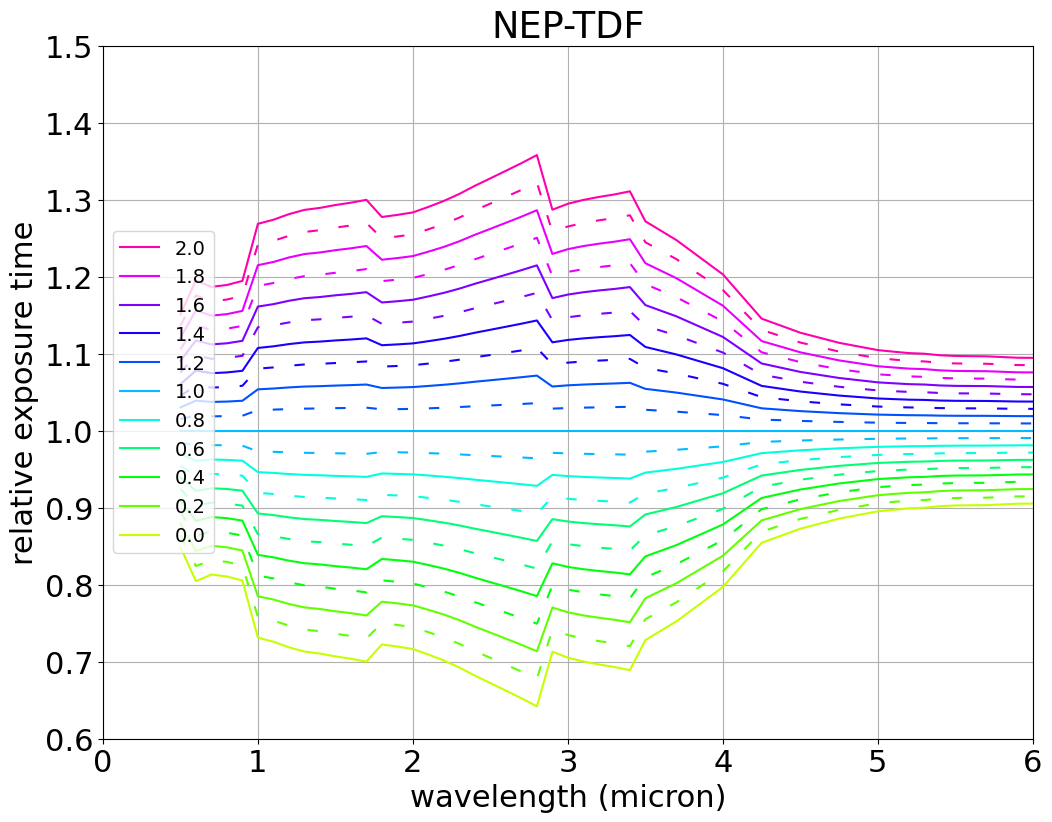

Plotting how the relative exposure time varies as a function of the strength of
the stray light component compared to PREDICTIONS, from  0.0 to 2.0 times
what was predicted pre-launch


In [83]:
# Copied over from Stray light NB
plt.rcParams['figure.figsize'] = [12, 9]
pp = PdfPages(observation_name + "_building_intuition.pdf")  # output 

cmap = plt.get_cmap('hsv')
colors = cmap(np.linspace(0.9,0,14)) #get 14 colors along the full range of hsv colormap
linestyles = ['solid' , (0, (5, 10))]#, 'dotted'] 
plt.rc('axes', prop_cycle=(cycler('color', colors) * cycler('linestyle', linestyles))) 
df = bkg_df[dateobs]

fig, ax = plt.subplots()

scale1=0.0;  scale2=2.0
for scaleby in np.linspace(scale2, scale1, 21) :
    df['new'] = df['total'] + df['straylight'] * (scaleby - 1)
    df['ratio'] = df['new'] / df['total']
    label = np.round(scaleby,2)
    if label*10 %2 : label = '_nolegend_' 
    df.plot(x='wave', y='ratio', label=str(label), lw=1.5, ax=ax)
plt.xlim(0,6) ; plt.ylim(0.6,1.5)
plt.xlabel("wavelength (micron)")
plt.ylabel("relative exposure time")
plt.title(observation_name)
plt.legend(fontsize=14, loc='center left')
plt.grid(visible=True)
pp.savefig()
plt.show()
pp.close()
print("Plotting how the relative exposure time varies as a function of the strength of")
print("the stray light component compared to PREDICTIONS, from ", scale1, "to", scale2, "times")
print("what was predicted pre-launch")

In [84]:
# compare any 2 fluxing dictionaries
dict1 = fluxing_dicts['marcia2']
dict2 = fluxing_dicts['martha2']
for (key, value) in dict1.items():
    print(key, value, end=' ')
    if key in dict2 : 
        frac_offset = (dict2[key]  - value)/value
        print(dict2[key], frac_offset)
    else : print('-------')

F070W_NRCB1 4.624 4.474 -0.03243944636678189
F090W_NRCB1 3.603 3.564 -0.010824313072439673
F115W_NRCB1 3.186 3.2719 0.026961707470182075
F140M_NRCB1 5.181 5.4412 0.05022196487164644
F150W_NRCB1 2.301 2.4124 0.04841373315949575
F162M+F150W2_NRCB1 4.914 5.0683 0.03140008140008142
F164N+F150W2_NRCB1 47.703 50.1895 0.05212460432257928
F182M+F150W2_NRCB1 3.623 -------
F187N_NRCB1 40.686 44.3043 0.0889323108686034
F200W_NRCB1 2.1 2.0223 -0.03700000000000005
F210M_NRCB1 4.579 4.7596 0.03944092596636822
F212N_NRCB1 40.32 42.2741 0.048464781746031665
F250M_NRCBLONG 1.534 1.6456 0.07275097783572354
F277W_NRCBLONG 0.399 0.4175 0.04636591478696732
F300M_NRCBLONG 0.9 0.9493 0.054777777777777786
F322W2_NRCBLONG 0.183 0.202 0.10382513661202196
F323N+F322W2_NRCBLONG 10.439 12.0673 0.1559823737905929
F335M_NRCBLONG 0.803 0.851 0.05977584059775832
F356W_NRCBLONG 0.351 0.376 0.0712250712250713
F360M_NRCBLONG 0.822 0.8776 0.06763990267639915
F405N+F444W_NRCBLONG 8.861 9.7108 0.09590339690779823
F410M_NRCB